# Quickstart Guide

This guide will demonstrates how to quickly:
- Add users from a CSV file to your organization
- Assign each user a Tracker for ArcGIS License
- Create a track view that includes mobile users and track viewers
- Generate a QR Code for quick sign in on the Android and iOS apps

In [1]:
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView
from arcgis.apps import build_tracker_url
import csv
import pandas as pd
import pyqrcode

admin_username = 'admin'
admin_password = 'password'
org = 'https://server.domain.com/webadapter'
users_csv = 'users.csv'
track_view_name = "Track View 1"

gis = GIS(org, admin_username, admin_password, verify_cert=False)

First we'll read the CSV file using pandas

In [2]:
df = pd.read_csv(users_csv)
df

,Email,First Name,Last Name,Username,Password,Role,User Type,Track Viewer
0,myemail@gmail.com,Jane,Doe,janedoe,password1,Viewer,Viewer,No
1,myemail2@gmail.com,John,Doe,johndoe,password1,Viewer,Viewer,Yes
2,myemail3@gmail.com,Bill,Doe,billdoe,password1,Viewer,Viewer,Yes


### Create users if necessary
If the user in the CSV file does not exist in the organization, we'll add them

In [3]:
users = []
for index, row in df.iterrows():
    u = gis.users.get(row["Username"])
    if u is None:
        users.append(gis.users.create(
            username=row["Username"], 
            password=row["Password"],
            firstname=row["First Name"],
            lastname=row["Last Name"],
            email=row["Email"],
            role=row["Role"],
            user_type=row["User Type"]
        ))
    else:
        users.append(u)

Each user is then assigned a Tracker for ArcGIS license so that they can use the mobile app

In [4]:
tracker_license = gis.admin.license.get('Tracker for ArcGIS')
for user in users:
    tracker_license.assign(username=user.username, entitlements=["tracker"])

### Create a new track view and add mobile users

In [5]:
track_view = gis.admin.location_tracking.create_track_view(track_view_name)
track_view.mobile_users.add(users)

### Create a Track Viewer role if necessary
In order to view other users tracks, track viewers need to have 2 specific privileges:
- the ability to join a group
- the ability to see others users tracks

If a role titled "Track Viewer" does not exist, we'll create one.

In [6]:
for role in gis.users.roles.all():
    if role.name.lower() == "Track Viewer".lower():
        track_viewer_role = role
        break
else:
    track_viewer_role = gis.users.roles.create(
        name='Track Viewer',
        description="A user that can use the Track Viewer web app to see others tracks",
        privileges=[
            "portal:user:joinGroup",
            "portal:user:viewTracks",
        ]
    )

### Add Track Viewers
We'll now add track viewers to the track view based on the "Track Viewer" column in the CSV file

In [7]:
for index, row in df[df['Track Viewer'] == "Yes"].iterrows():
    user = gis.users.get(row["Username"])
    if "portal:user:joinGroup" not in user.privileges or "portal:user:viewTracks" not in user.privileges:
        user.update_role(track_viewer_role)
    track_view.viewers.add(user)

### Let's confirm everything is all set

In [8]:
track_view.viewers.list()

['billdoe', 'johndoe', 'admin']

In [9]:
track_view.mobile_users.list()

['janedoe', 'johndoe', 'billdoe']

### Generate a QR code for quick sign in
Finally, a QR code is generated which can be scanned by a mobile device to quickly sign into the Tracker app.

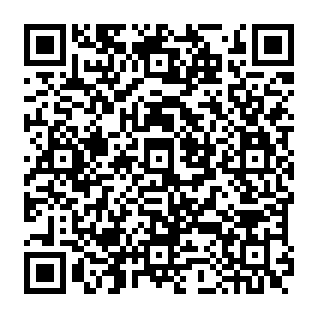

In [10]:
from IPython.core.display import Image
url = pyqrcode.create(build_tracker_url(org))
url.png("qr.png", scale=6)
Image(filename="qr.png")